In [1]:
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload

In [3]:
orders_filenames = [
    'LUNA_FullChannel_GDAX_20220511_17hr.json',
    'LUNA_FullChannel_GDAX_20220511_18hr.json',
    'LUNA_FullChannel_GDAX_20220511_19hr.json',
    'LUNA_FullChannel_GDAX_20220511_20hr.json',
]

tickers_filenames = [
    'LUNA_Ticker_GDAX_20220511_17hr.json',
    'LUNA_Ticker_GDAX_20220511_18hr.json',
    'LUNA_Ticker_GDAX_20220511_19hr.json',
    'LUNA_Ticker_GDAX_20220511_20hr.json',
]

In [4]:
# orders_df = pd.read_json(f'../../luna_crash_dataset/luna/{orders_filenames[0]}', lines=True)

# for filename in orders_filenames[1:]:
#     tmp_df = pd.read_json(f'../../luna_crash_dataset/luna/{filename}', lines=True)
#     orders_df = pd.concat([orders_df, tmp_df])

In [5]:
ticker_df = pd.read_json(f'../../luna_crash_dataset/luna/{tickers_filenames[0]}', lines=True)

for filename in tickers_filenames[1:]:
    tmp_df = pd.read_json(f'../../luna_crash_dataset/luna/{filename}', lines=True)
    ticker_df = pd.concat([ticker_df, tmp_df])

## 1. Preprocessing

### 1.1 Add timestamp

In [6]:
# orders_df.time = pd.to_datetime(orders_df.time)
# orders_df['timestamp'] = orders_df['time'].astype('int64')

ticker_df.time = pd.to_datetime(ticker_df.time)
ticker_df['timestamp'] = ticker_df['time'].astype('int64')

### 1.2 Set ticker interval borders

In [7]:
ticker_df.sort_values(by='sequence', inplace=True)
ticker_df['sequence_start'] = ticker_df['sequence']
ticker_df['sequence_end'] = ticker_df['sequence'].shift(-1)
ticker_df.dropna(subset=['sequence_end'], inplace=True)
ticker_df.sequence_end = ticker_df.sequence_end.astype(int)

### 1.3 Add middle price

In [8]:
ticker_df['mid_price'] = (ticker_df['best_bid'] + ticker_df['best_ask']) / 2

### 1.4 Add column mapping ticker to orders

In [28]:
def find_matching_range(sequence):
    mask = (ticker_df.sequence_start <= sequence) & (sequence < ticker_df.sequence_end)
    if mask.any():
        return ticker_df[mask].sequence.iloc[0]


# orders_df['ticker_sequence'] = orders_df.sequence.apply(find_matching_range)
# orders_df.to_csv('full_channel_df_with_ticker_sequence.csv', index=False)
# orders_df = pd.read_csv('full_channel_df_with_ticker_sequence.csv')
# orders_df.time = pd.to_datetime(orders_df.time)
# orders_df.drop(orders_df[orders_df.price == ''].index, inplace=True)
# orders_df.price = orders_df.price.astype(float)
# orders_df.dropna(subset=['ticker_sequence'], inplace=True)
# orders_df = orders_df.merge(ticker_df.drop(columns=['price', 'timestamp', 'side', 'time', 'type', 'trade_id']), left_on='ticker_sequence', right_on='sequence', how='inner')
# orders_df.to_csv('orders_df_with_ticker.csv', index=False)
orders_df = pd.read_csv('orders_df_with_ticker.csv')
orders_df.time = pd.to_datetime(orders_df.time)

### 1.5 Add active/passive area fields

In [10]:
alpha = 0.5

passive_bid_area = orders_df.price.between(orders_df.best_bid - 2 * alpha, orders_df.best_bid - alpha)
passive_ask_area = orders_df.price.between(orders_df.best_ask + alpha, orders_df.best_ask + 2 * alpha)
passive_area_mask = passive_bid_area | passive_ask_area

active_area_mask = orders_df.price.between(orders_df.best_bid - alpha, orders_df.best_ask + alpha)

In [11]:
orders_df['active_area'] = active_area_mask
orders_df['passive_area'] = passive_area_mask

In [12]:
orders_df[orders_df.active_area].shape

(2267121, 38)

### 1.6 Get cancelled orders

In [14]:
passive_area_orders = orders_df[orders_df['passive_area']]
passive_area_orders.shape

(44212, 38)

In [15]:
active_area_orders = orders_df[orders_df['active_area']]
active_area_orders.shape

(2267121, 38)

In [16]:
def prepare_dataset(orders_df):
    aggregated_orders = (
        orders_df[['order_id', 'reason', 'size', 'order_type', 'type', 'time', 'price', 'mid_price', 'best_bid', 'best_ask', 'side']]
        .groupby('order_id')
        .agg({'order_type': list, 'type': list, 'reason': list, 'size': list, 'time': list, 'price': list, 'mid_price': list, 'best_bid': list, 'best_ask': list, 'side': list})
    )
    aggregated_orders['time_received'] = aggregated_orders.time.apply(lambda x: x[0])
    aggregated_orders['price_received'] = aggregated_orders.price.apply(lambda x: x[0])
    aggregated_orders['mid_price_received'] = aggregated_orders.mid_price.apply(lambda x: x[0])
    aggregated_orders['mid_price_cancelled'] = aggregated_orders.mid_price.apply(lambda x: x[-1])
    aggregated_orders['mid_price_change'] = np.abs(aggregated_orders.mid_price_cancelled - aggregated_orders.mid_price_received) / aggregated_orders.mid_price_received
    aggregated_orders['bid_price_received'] = aggregated_orders.best_bid.apply(lambda x: x[0])
    aggregated_orders['bid_price_cancelled'] = aggregated_orders.best_bid.apply(lambda x: x[-1])
    aggregated_orders['bid_price_change'] = np.abs(aggregated_orders.bid_price_received - aggregated_orders.bid_price_cancelled) / aggregated_orders.bid_price_received
    aggregated_orders['ask_price_received'] = aggregated_orders.best_ask.apply(lambda x: x[0])
    aggregated_orders['ask_price_cancelled'] = aggregated_orders.best_ask.apply(lambda x: x[-1])
    aggregated_orders['ask_price_change'] = np.abs(aggregated_orders.ask_price_received - aggregated_orders.ask_price_cancelled) / aggregated_orders.ask_price_received
    aggregated_orders['spread_received'] = aggregated_orders.ask_price_received - aggregated_orders.bid_price_received
    aggregated_orders['spread_cancelled'] = aggregated_orders.ask_price_cancelled - aggregated_orders.bid_price_cancelled
    aggregated_orders['spread_change'] = aggregated_orders.spread_cancelled - aggregated_orders.spread_received
    aggregated_orders['order_size'] = aggregated_orders['size'].apply(lambda x: x[0])
    aggregated_orders['side'] = aggregated_orders['side'].apply(lambda x: x[0])

    cancelled_orders = aggregated_orders[aggregated_orders['reason'].apply(lambda x: 'canceled' in x)].copy()
    cancelled_orders['time_cancelled'] = aggregated_orders.time.apply(lambda x: x[-1])

    cancelled_without_modifying = aggregated_orders[aggregated_orders['reason'].apply(lambda x: 'canceled' in x and len(x) == 3)].copy()
    cancelled_without_modifying['time_cancelled'] = aggregated_orders.time.apply(lambda x: x[-1])
    return aggregated_orders, cancelled_orders, cancelled_without_modifying

In [17]:
passive_aggregated_orders, passive_cancelled_orders, passive_cancelled_without_modifying = prepare_dataset(orders_df[orders_df['passive_area']])
active_aggregated_orders, active_cancelled_orders, active_cancelled_without_modifying = prepare_dataset(orders_df[orders_df['active_area']])
full_aggregated_orders, full_cancelled_orders, full_cancelled_without_modifying = prepare_dataset(orders_df)

In [30]:
from datetime import timedelta


def add_targets(orders_df):
    orders_df.loc[:, 'order_size'] = orders_df['size'].apply(lambda x: x[0])
    orders_df.loc[:, 'duration'] = orders_df.time.apply(lambda x: x[2] - x[0])
    orders_df.loc[:, 'duration_sec'] = orders_df.duration.apply(lambda x: x.total_seconds())
    orders_df.loc[:, '10_sec'] = orders_df.duration < timedelta(seconds=10)
    orders_df.loc[:, '5_sec'] = orders_df.duration < timedelta(seconds=5)
    orders_df.loc[:, '3_sec'] = orders_df.duration < timedelta(seconds=3)
    orders_df.loc[:, '2_sec'] = orders_df.duration < timedelta(seconds=2)
    orders_df.loc[:, '1_sec'] = orders_df.duration < timedelta(seconds=1)
    return orders_df

In [19]:
full_cancelled_without_modifying = add_targets(full_cancelled_without_modifying)
active_cancelled_without_modifying = add_targets(active_cancelled_without_modifying)
passive_cancelled_without_modifying = add_targets(passive_cancelled_without_modifying)

In [20]:
from matplotlib import pyplot as plt


def plot_price_received_vs_time(orders_df, sample, order_sizes: list[int]):
    num_rows = (len(order_sizes) + 1) // 2
    fig, axis = plt.subplots(num_rows, 2, figsize=(16, 6 * num_rows))
    axis = axis.flatten()
    price_sample = orders_df.iloc[::100]

    y_min, y_max = sample.price_received.min(), sample.price_received.max()
    for i, order_size in enumerate(order_sizes):
        sample = sample[sample.order_size > order_size]
        buy_orders = sample[sample.side == 'buy']
        sell_orders = sample[sample.side == 'sell']
        
        axis[i].scatter(buy_orders.time_received, buy_orders.price_received, alpha=0.2, color='green')
        axis[i].scatter(sell_orders.time_received, sell_orders.price_received, alpha=0.2, color='red')
        axis[i].scatter(price_sample.time, price_sample.mid_price, alpha=1, s=0.1, color='blue')
        axis[i].set_xlabel('Time Received')
        axis[i].set_ylabel('Price Received')
        axis[i].set_title(f'Price Received vs Time for Canceled Orders (Size > {order_size})')
        axis[i].set_ylim(y_min, y_max)
    
    for i in range(len(order_sizes), len(axis)):
        axis[i].set_visible(False)

In [22]:
from matplotlib import pyplot as plt

def draw_order_book(buy_df, sell_df, best_bid, best_ask):   
    # Create a single figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot buy order book
    ax.hist(buy_df['price'], weights=buy_df['volume'], bins=50, alpha=0.5, label='Buy Orders')

    ax.hist(sell_df['price'], weights=sell_df['volume'], bins=50, alpha=0.5, label='Sell Orders')

    # Add vertical lines for best bid and ask
    ax.axvline(x=best_bid, color='g', linestyle='--', label='Best Bid')
    ax.axvline(x=best_ask, color='r', linestyle='--', label='Best Ask')

    ax.set_xlabel('Price')
    ax.set_ylabel('Volume')
    ax.set_title('Order Book Volume Distribution')
    ax.legend()

    plt.tight_layout()
    plt.show()

In [24]:
# import pandas as pd
# import numpy as np

# from preprocessing import model_order_book


# buy_order_book, sell_order_book, best_bid, best_ask, bid_volume_list, ask_volume_list = model_order_book(orders_df)

# buy_df = pd.DataFrame({
#     'price': list(buy_order_book.keys()),
#     'volume': list(buy_order_book.values())
# })

# sell_df = pd.DataFrame({
#     'price': list(sell_order_book.keys()),
#     'volume': list(sell_order_book.values())
# })

# orders_df.loc[:, 'buy_volume_lob'] = bid_volume_list[1:] + [buy_df.volume.sum()]
# orders_df.loc[:, 'sell_volume_lob'] = ask_volume_list[1:] + [sell_df.volume.sum()]

# orders_df.to_csv('orders_df_with_lob.csv', index=False)

orders_df = pd.read_csv('orders_df_with_lob.csv')

0 / 2375073
1000 / 2375073
2000 / 2375073
3000 / 2375073
4000 / 2375073
5000 / 2375073
6000 / 2375073
7000 / 2375073
8000 / 2375073
9000 / 2375073
10000 / 2375073
11000 / 2375073
12000 / 2375073
13000 / 2375073
14000 / 2375073
15000 / 2375073
16000 / 2375073
17000 / 2375073
18000 / 2375073
19000 / 2375073
20000 / 2375073
21000 / 2375073
22000 / 2375073
23000 / 2375073
24000 / 2375073
25000 / 2375073
26000 / 2375073
27000 / 2375073
28000 / 2375073
29000 / 2375073
30000 / 2375073
31000 / 2375073
32000 / 2375073
33000 / 2375073
34000 / 2375073
35000 / 2375073
36000 / 2375073
37000 / 2375073
38000 / 2375073
39000 / 2375073
40000 / 2375073
41000 / 2375073
42000 / 2375073
43000 / 2375073
44000 / 2375073
45000 / 2375073
46000 / 2375073
47000 / 2375073
48000 / 2375073
49000 / 2375073
50000 / 2375073
51000 / 2375073
52000 / 2375073
53000 / 2375073
54000 / 2375073
55000 / 2375073
56000 / 2375073
57000 / 2375073
58000 / 2375073
59000 / 2375073
60000 / 2375073
61000 / 2375073
62000 / 2375073
63000

| Название фичи            | Что означает                                                            | Почему важно для spoofing                               |
| :----------------------- | :---------------------------------------------------------------------- | :------------------------------------------------------ |
| Bid-Ask Volume Imbalance | (Σ объём bid - Σ объём ask) / (Σ объём bid + Σ объём ask)               | Спуферы часто создают фейковый перекос                  |
| Order Book Slope         | Наклон стакана заявок (например, средняя разница объема между уровнями) | Крутые "склоны" в стакане бывают аномальными            |
| Cancel-to-Trade Ratio    | Количество отмененных ордеров к количеству исполненных                  | Спуферы часто отменяют ордера быстро                    |
| Midprice Movement        | Изменение средней цены между бидом и аском за время                     | Атакующие иногда толкают цену                           |
| Spread Width             | Разница между лучшей ценой продажи и покупки                            | В моменты манипуляций спред может сжиматься/расширяться |
| Large Order Appearance   | Появление крупных ордеров без исполнения                                | Типичная спуфинг-тактика                                |
| Order Book Volatility    | Изменение общей картины стакана за короткий промежуток                  | Отражает неустойчивость рынка                           |


1. Market orders  
2. Features in active/passive windows

In [31]:
import pandas as pd
import numpy as np


# canceled_to_merge = full_cancelled_without_modifying.reset_index().drop(
#     columns=[
#         'order_type',
#         'type',
#         'reason',
#         'size',
#         'time',
#         'price',
#         'mid_price',
#         'best_bid',
#         'best_ask',
#         'time_received',
#         'price_received',
#         'mid_price_received',
#         'mid_price_cancelled',
#         'mid_price_change',
#         'bid_price_received',
#         'bid_price_cancelled',
#         'bid_price_change',
#         'ask_price_received',
#         'ask_price_cancelled',
#         'ask_price_change',
#         'spread_received',
#         'spread_cancelled',
#         'spread_change',
#         'order_size',
#         'time_cancelled',
#         'duration',
#         'duration_sec'
#     ]
# )
# full_df = pd.merge(orders_df, canceled_to_merge, on='order_id', how='left')
# full_df.to_csv('orders_df_with_cancellations.csv')

full_df = pd.read_csv('orders_df_with_features.csv')

### Construct features

In [71]:
from preprocessing import cancelled_rolling_sum, trade_rolling_sum, value_change_rolling

Text(0.5, 1.0, 'Order Size Distribution')

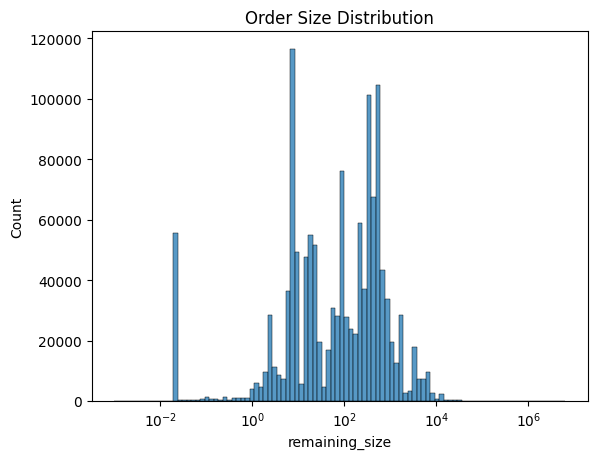

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(full_df['remaining_size'], bins=100, log_scale=True)
plt.title("Order Size Distribution")

### Orders category
1. Tiny (size < 1)  
2. Small (1 <= size < 10)  
3. Medium (10 <= size < 100)  
4. Large (100 <= size < 1000)  
5. Very large (1000 <= size < 10000)
6. Huge (10000 < size)  


In [43]:
def categorize_size(size):
    if np.isnan(size):
        return size
    elif size < 1:
        return 'tiny'
    elif size < 10:
        return 'small'
    elif size < 100:
        return 'medium'
    elif size < 1000:
        return 'large'
    elif size < 10000:
        return 'very_large'
    else:
        return 'huge'

In [35]:
# order remaining size category
full_df.loc[:, 'remaining_size_category'] = full_df['remaining_size'].apply(categorize_size)

# relative price
full_df.loc[:, 'relative_price'] = (full_df['price'] - full_df['mid_price']) / full_df['mid_price']

# bid-ask imabalance
full_df.loc[:, 'bid_ask_imbalance'] = ((full_df.buy_volume_lob - full_df.sell_volume_lob) / (full_df.buy_volume_lob + full_df.sell_volume_lob)).fillna(0)

# order book slope


# cancel-to-trade ratio
full_df = cancelled_rolling_sum(full_df, 1_000_000_000, 'timestamp', '1_sec', '1_sec_rolling_sum', sort_by='sequence_x')
full_df = cancelled_rolling_sum(full_df, 2_000_000_000, 'timestamp', '2_sec', '2_sec_rolling_sum', sort_by='sequence_x')
full_df = cancelled_rolling_sum(full_df, 3_000_000_000, 'timestamp', '3_sec', '3_sec_rolling_sum', sort_by='sequence_x')
full_df = cancelled_rolling_sum(full_df, 5_000_000_000, 'timestamp', '5_sec', '5_sec_rolling_sum', sort_by='sequence_x')
full_df = cancelled_rolling_sum(full_df, 10_000_000_000, 'timestamp', '10_sec', '10_sec_rolling_sum', sort_by='sequence_x')

full_df = trade_rolling_sum(full_df, 1_000_000_000, 'timestamp', 'trade_id_x', 'trade_1_sec_rolling_sum', sort_by='sequence_x')
full_df = trade_rolling_sum(full_df, 2_000_000_000, 'timestamp', 'trade_id_x', 'trade_2_sec_rolling_sum', sort_by='sequence_x')
full_df = trade_rolling_sum(full_df, 3_000_000_000, 'timestamp', 'trade_id_x', 'trade_3_sec_rolling_sum', sort_by='sequence_x')
full_df = trade_rolling_sum(full_df, 5_000_000_000, 'timestamp', 'trade_id_x', 'trade_5_sec_rolling_sum', sort_by='sequence_x')
full_df = trade_rolling_sum(full_df, 10_000_000_000, 'timestamp', 'trade_id_x', 'trade_10_sec_rolling_sum', sort_by='sequence_x')

full_df.loc[:, 'cancel_trade_ratio_1_sec'] = (full_df.loc[:, '1_sec_rolling_sum'] / full_df.loc[:, 'trade_1_sec_rolling_sum']).fillna(0)
full_df.loc[:, 'cancel_trade_ratio_2_sec'] = (full_df.loc[:, '2_sec_rolling_sum'] / full_df.loc[:, 'trade_2_sec_rolling_sum']).fillna(0)
full_df.loc[:, 'cancel_trade_ratio_3_sec'] = (full_df.loc[:, '3_sec_rolling_sum'] / full_df.loc[:, 'trade_3_sec_rolling_sum']).fillna(0) 
full_df.loc[:, 'cancel_trade_ratio_5_sec'] = (full_df.loc[:, '5_sec_rolling_sum'] / full_df.loc[:, 'trade_5_sec_rolling_sum']).fillna(0)
full_df.loc[:, 'cancel_trade_ratio_10_sec'] = (full_df.loc[:, '10_sec_rolling_sum'] / full_df.loc[:, 'trade_10_sec_rolling_sum']).fillna(0)

# midprice movement
full_df = value_change_rolling(full_df, 1_000_000_000, 'timestamp', 'mid_price', 'mid_price_change_1_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 2_000_000_000, 'timestamp', 'mid_price', 'mid_price_change_2_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 3_000_000_000, 'timestamp', 'mid_price', 'mid_price_change_3_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 5_000_000_000, 'timestamp', 'mid_price', 'mid_price_change_5_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 10_000_000_000, 'timestamp', 'mid_price', 'mid_price_change_10_sec', sort_by='sequence_x')

# spread width
full_df.loc[:, 'spread_width'] = (full_df['best_ask'] - full_df['best_bid']) / full_df['mid_price']

# large orders

# sell order book volatility
full_df = value_change_rolling(full_df, 1_000_000_000, 'timestamp', 'sell_volume_lob', 'sell_volume_lob_change_1_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 2_000_000_000, 'timestamp', 'sell_volume_lob', 'sell_volume_lob_change_2_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 3_000_000_000, 'timestamp', 'sell_volume_lob', 'sell_volume_lob_change_3_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 5_000_000_000, 'timestamp', 'sell_volume_lob', 'sell_volume_lob_change_5_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 10_000_000_000, 'timestamp', 'sell_volume_lob', 'sell_volume_lob_change_10_sec', sort_by='sequence_x')

# buy order book volatility
full_df = value_change_rolling(full_df, 1_000_000_000, 'timestamp', 'buy_volume_lob', 'buy_volume_lob_change_1_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 2_000_000_000, 'timestamp', 'buy_volume_lob', 'buy_volume_lob_change_2_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 3_000_000_000, 'timestamp', 'buy_volume_lob', 'buy_volume_lob_change_3_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 5_000_000_000, 'timestamp', 'buy_volume_lob', 'buy_volume_lob_change_5_sec', sort_by='sequence_x')
full_df = value_change_rolling(full_df, 10_000_000_000, 'timestamp', 'buy_volume_lob', 'buy_volume_lob_change_10_sec', sort_by='sequence_x')

In [13]:
full_df.to_csv('full_df_with_features.csv', index=False)

In [48]:
full_df = full_df[full_df.type == 'open']

In [50]:
full_df.columns

Index(['order_id', 'order_type', 'size', 'price', 'client_oid', 'type',
       'side_x', 'product_id_x', 'time', 'sequence_x', 'remaining_size',
       'trade_id_x', 'maker_order_id', 'taker_order_id', 'reason', 'funds',
       'old_size', 'new_size', 'old_funds', 'new_funds', 'timestamp',
       'ticker_sequence', 'sequence_y', 'product_id_y', 'open_24h',
       'volume_24h', 'low_24h', 'high_24h', 'volume_30d', 'best_bid',
       'best_ask', 'trade_id_y', 'last_size', 'sequence_start', 'sequence_end',
       'mid_price', 'active_area', 'passive_area', 'buy_volume_lob',
       'sell_volume_lob', 'side_y', '10_sec', '5_sec', '3_sec', '2_sec',
       '1_sec', 'bid_ask_imbalance', '1_sec_rolling_sum', '2_sec_rolling_sum',
       '3_sec_rolling_sum', '5_sec_rolling_sum', '10_sec_rolling_sum',
       'trade_1_sec_rolling_sum', 'trade_2_sec_rolling_sum',
       'trade_3_sec_rolling_sum', 'trade_5_sec_rolling_sum',
       'trade_10_sec_rolling_sum', 'cancel_trade_ratio_1_sec',
       'cancel

### Prepare train and target datasets

In [140]:
train_df = full_df.drop(
    columns=
    [
        'order_id', 'order_type', 'size', 'price', 'client_oid', 'type',
        'product_id_x', 'time', 'sequence_x', 'remaining_size', 'trade_id_x',
        'maker_order_id', 'taker_order_id', 'reason', 'funds', 'old_size',
        'new_size', 'old_funds', 'new_funds', 'timestamp', 'ticker_sequence',
        'sequence_y', 'product_id_y', 'open_24h', 'volume_24h', 'low_24h',
        'high_24h', 'volume_30d', 'best_bid', 'best_ask', 'trade_id_y',
        'last_size', 'sequence_start', 'sequence_end', 'mid_price', 'side_y',
        'buy_volume_lob', 'sell_volume_lob',
        '1_sec_rolling_sum', '2_sec_rolling_sum', '3_sec_rolling_sum',
        '5_sec_rolling_sum', '10_sec_rolling_sum',
        'trade_1_sec_rolling_sum', 'trade_2_sec_rolling_sum',
        'trade_3_sec_rolling_sum', 'trade_5_sec_rolling_sum',
        'trade_10_sec_rolling_sum',
    ]
).rename(columns={'side_x': 'buy'})

In [141]:
train_df.columns

Index(['buy', 'active_area', 'passive_area', '10_sec', '5_sec', '3_sec',
       '2_sec', '1_sec', 'bid_ask_imbalance', 'cancel_trade_ratio_1_sec',
       'cancel_trade_ratio_2_sec', 'cancel_trade_ratio_3_sec',
       'cancel_trade_ratio_5_sec', 'cancel_trade_ratio_10_sec',
       'mid_price_change_1_sec', 'mid_price_change_2_sec',
       'mid_price_change_3_sec', 'mid_price_change_5_sec',
       'mid_price_change_10_sec', 'spread_width', 'relative_price',
       'sell_volume_lob_change_1_sec', 'sell_volume_lob_change_2_sec',
       'sell_volume_lob_change_3_sec', 'sell_volume_lob_change_5_sec',
       'sell_volume_lob_change_10_sec', 'buy_volume_lob_change_1_sec',
       'buy_volume_lob_change_2_sec', 'buy_volume_lob_change_3_sec',
       'buy_volume_lob_change_5_sec', 'buy_volume_lob_change_10_sec',
       'remaining_size_category'],
      dtype='object')

In [142]:
train_df = train_df.reset_index(drop='index')

In [143]:
train_df.loc[:, 'buy'] = train_df['buy'] == 'buy'

In [144]:
nan_columns = train_df.isna().sum()[train_df.isna().sum() > 0].index.tolist()
print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
['10_sec', '5_sec', '3_sec', '2_sec', '1_sec']


Targets with NaN values are trades (not cancelled) orders

In [145]:
train_df.loc[:, nan_columns] = train_df[nan_columns].infer_objects(copy=False).fillna(False)

/tmp/ipykernel_328486/529693385.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.loc[:, nan_columns] = train_df[nan_columns].infer_objects(copy=False).fillna(False)


In [146]:
size_dummies = pd.get_dummies(train_df['remaining_size_category'], prefix='remaining_size')
train_df = pd.concat([train_df.drop('remaining_size_category', axis=1), size_dummies], axis=1)

In [147]:
train_df.columns

Index(['buy', 'active_area', 'passive_area', '10_sec', '5_sec', '3_sec',
       '2_sec', '1_sec', 'bid_ask_imbalance', 'cancel_trade_ratio_1_sec',
       'cancel_trade_ratio_2_sec', 'cancel_trade_ratio_3_sec',
       'cancel_trade_ratio_5_sec', 'cancel_trade_ratio_10_sec',
       'mid_price_change_1_sec', 'mid_price_change_2_sec',
       'mid_price_change_3_sec', 'mid_price_change_5_sec',
       'mid_price_change_10_sec', 'spread_width', 'relative_price',
       'sell_volume_lob_change_1_sec', 'sell_volume_lob_change_2_sec',
       'sell_volume_lob_change_3_sec', 'sell_volume_lob_change_5_sec',
       'sell_volume_lob_change_10_sec', 'buy_volume_lob_change_1_sec',
       'buy_volume_lob_change_2_sec', 'buy_volume_lob_change_3_sec',
       'buy_volume_lob_change_5_sec', 'buy_volume_lob_change_10_sec',
       'remaining_size_huge', 'remaining_size_large', 'remaining_size_medium',
       'remaining_size_small', 'remaining_size_tiny',
       'remaining_size_very_large'],
      dtype='objec

In [148]:
train_df['10_sec'].to_csv('10_sec_target.csv', index=False)
train_df['5_sec'].to_csv('5_sec_target.csv', index=False)
train_df['3_sec'].to_csv('3_sec_target.csv', index=False)
train_df['2_sec'].to_csv('2_sec_target.csv', index=False)
train_df['1_sec'].to_csv('1_sec_target.csv', index=False)

In [149]:
train_df.drop(columns=['10_sec', '5_sec', '3_sec', '2_sec', '1_sec']).to_csv('train_df.csv', index=False)